# Walkthrough - RBIG

In [3]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
# from rbig_jax.information.reduction import information_reduction
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob
# from rbig_jax.models.rbig import RBIGFlow, RBIGFlowJit
# from rbig_jax.transforms.block import (
#     init_gauss_hist_block, init_gauss_hist_block_params,
#     init_gauss_kde_block, init_gauss_kde_block_params
# )

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


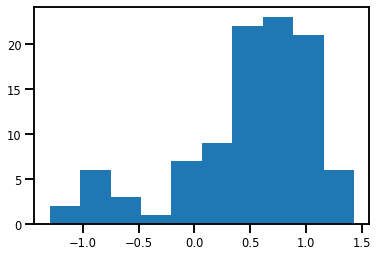

In [4]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

In [5]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: emanjohnson91 (use `wandb login --relogin` to force relogin)


In [6]:

# config parameters
wandb.config.n_samples = 10_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

## Data

In [7]:
def plot_joint(data, color: str = "red", title: str = "", kind="kde", logger=None):

    plt.figure()
    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    

def plot_joint_prob(data, probs, cmap="Reds", title="", logger=None):

    fig, ax = plt.subplots()
    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap=cmap)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(h,)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

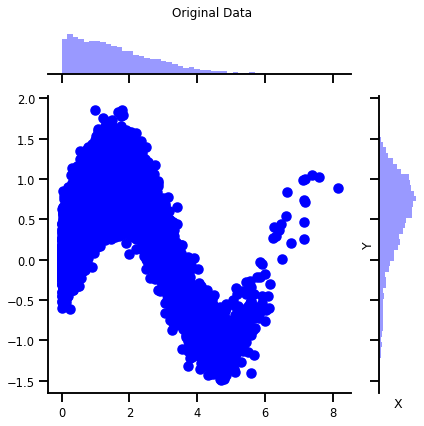

In [8]:
# %%wandb
# get data
data = get_classic(10_000)

# plot data
plot_joint(data, "blue", "Original Data", kind='scatter', logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

## RBIG Block

In [11]:
from rbig_jax.transforms.block import (
    get_gauss_hist_block_params,
    forward_gauss_block_transform,
    inverse_gauss_block_transform)

ImportError: cannot import name 'get_params_marginal' from 'rbig_jax.transforms.marginal' (/home/emmanuel/code/rbig_jax/rbig_jax/transforms/marginal.py)

In [ ]:
# initialize transformation
init_rbig_transform = init_gauss_hist_block_params()

# forward transformation
X_g, params = init_rbig_transform(np.array(data))

In [ ]:
# plot
sns.jointplot(X_g[:1_000, 0], X_g[:1_000, 1], kind='kde')

### Forward Transformation

In [ ]:
X_g_f = forward_gauss_block_transform(np.array(data), params)

In [ ]:
sns.jointplot(X_g_f[:1_000, 0], X_g_f[:1_000, 1], kind='kde')

### Inverse Transform

In [ ]:
X_approx = inverse_gauss_block_transform(X_g_f, params)

In [ ]:
sns.jointplot(X_approx[:1_000, 0], X_approx[:1_000, 1], kind='kde')

#### Speed

In [ ]:
%%time

# initialize transformation
init_rbig_transform = init_gauss_hist_block_params()

# forward transformation
X_g, params = init_rbig_transform(np.array(data))

In [ ]:
%timeit init_rbig_transform(np.array(data).block_until_ready())

In [ ]:
%%time


# initialize transformation
init_rbig_transform_jitted = jax.jit(init_gauss_hist_block_params())

# forward transformation
X_g, params = init_rbig_transform_jitted(np.array(data))

In [ ]:
%timeit init_rbig_transform_jitted(np.array(data).block_until_ready())

## Gaussianization

In [ ]:
%%time

# rbig_block = init_gauss_hist_block_params()
rbig_block = init_gauss_kde_block_params()

rbig_flow = RBIGFlow(rbig_block, tol_layers=20, max_layers=1_000)

X_trans = rbig_flow.fit_transform(np.array(data))


In [ ]:
plt.plot(rbig_flow.losses)

In [ ]:
plt.plot(np.cumsum(rbig_flow.losses))

In [ ]:
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

In [ ]:
X_trans = rbig_flow.transform(np.array(data))

In [ ]:
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

In [ ]:
X_approx = rbig_flow.inverse_transform(X_trans)

In [ ]:
sns.jointplot(X_approx[:1_000, 0], X_approx[:1_000, 1], kind='kde')

In [ ]:
X_samples = rbig_flow.sample(10_000)

sns.jointplot(X_samples[:1_000, 0], X_samples[:1_000, 1], kind='kde')

## Speed

In [ ]:
%%time

# rbig_block = init_gauss_hist_block_params()
rbig_block = init_gauss_kde_block_params()
rbig_flow = RBIGFlowJit(rbig_block, tol_layers=60, max_layers=1_000)

X_trans = rbig_flow.fit_transform(np.array(data))

In [ ]:
print(rbig_flow.n_layers)

In [ ]:
plt.plot(rbig_flow.losses)

In [ ]:
X_trans = rbig_flow.transform(np.array(data))

sns.jointplot(X_trans[:None, 0], X_trans[:None, 1], joint_kws={'s':1})

In [ ]:
X_approx = rbig_flow.inverse_transform(X_trans)

sns.jointplot(X_approx[:None, 0], X_approx[:None, 1], joint_kws={'s':1}, color='red')

In [ ]:
X_samples = rbig_flow.sample(10_000)

sns.jointplot(X_samples[:None, 0], X_samples[:None, 1], joint_kws={'s':1}, color='orange')